https://www.kaggle.com/competitions/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/code?competitionId=7173

Catch Me If You Can ("Alice")

Будем решать задачу идентификации взломщика по его поведению в сети Интернет. Это сложная и интересная задача на стыке анализа данных и поведенческой психологии. В качестве примера, компания Яндекс решает задачу идентификации взломщика почтового ящика по его поведению. В двух словах, взломщик будет себя вести не так, как владелец ящика: он может не удалять сообщения сразу по прочтении, как это делал хозяин, он будет по-другому ставить флажки сообщениям и даже по-своему двигать мышкой. Тогда такого злоумышленника можно идентифицировать и "выкинуть" из почтового ящика, предложив хозяину войти по SMS-коду. Этот пилотный проект описан в статье на Хабрахабре. Похожие вещи делаются, например, в Google Analytics и описываются в научных статьях, найти можно многое по фразам "Traversal Pattern Mining" и "Sequential Pattern Mining".

В этом соревновании будем решать похожую задачу: алгоритм будет анализировать последовательность из нескольких веб-сайтов, посещенных подряд одним и тем же человеком, и определять, Элис это или взломщик (кто-то другой).

В обучающей выборке train_sessions.csv:

Признаки site_i – это индексы посещенных сайтов (расшифровка дана в pickle-файле со словарем site_dic.pkl)
Признаки time_j – время посещения сайтов site_j
Целевой признак target – факт того, что сессия принадлежит Элис (то есть что именно Элис ходила по всем этим сайтам)
Задача – сделать прогнозы для сессий в тестовой выборке (test_sessions.csv), определить, принадлежат ли они Элис.

In [2]:
#импорт библиотек
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd
import pickle

Загрузим тренировочный и тестовый наборы и посмотрим на часть данных:

In [4]:
train_df = pd.read_csv('alice_data/train_sessions.csv',
                      index_col='session_id')
test_df = pd.read_csv('alice_data/test_sessions.csv',
                     index_col='session_id')

In [12]:
# размер датафрейма
print(train_df.shape)
# названия столбцов
print(train_df.columns)

(253561, 21)
Index(['site1', 'time1', 'site2', 'time2', 'site3', 'time3', 'site4', 'time4',
       'site5', 'time5', 'site6', 'time6', 'site7', 'time7', 'site8', 'time8',
       'site9', 'time9', 'site10', 'time10', 'target'],
      dtype='object')


In [11]:
# первые 5 объектов датафрейма
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


In [13]:
# информация общая
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 253561 entries, 1 to 253561
Data columns (total 21 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   site1   253561 non-null  int64  
 1   time1   253561 non-null  object 
 2   site2   250098 non-null  float64
 3   time2   250098 non-null  object 
 4   site3   246919 non-null  float64
 5   time3   246919 non-null  object 
 6   site4   244321 non-null  float64
 7   time4   244321 non-null  object 
 8   site5   241829 non-null  float64
 9   time5   241829 non-null  object 
 10  site6   239495 non-null  float64
 11  time6   239495 non-null  object 
 12  site7   237297 non-null  float64
 13  time7   237297 non-null  object 
 14  site8   235224 non-null  float64
 15  time8   235224 non-null  object 
 16  site9   233084 non-null  float64
 17  time9   233084 non-null  object 
 18  site10  231052 non-null  float64
 19  time10  231052 non-null  object 
 20  target  253561 non-null  int64  
dtypes: float64(9), 

Датасет обучающих данных содержит следующие признаки:
- site_i – это индексы посещенных сайтов;
- time_j – время посещения сайтов site_j;
- target (целевой признак) – имеет значение 1 для сеансов Алисы и 0 для сеансов других пользователей.

Пользовательские сессии выбираются таким образом, чтобы они не превышали полчаса и/или содержали более десяти веб-сайтов. 

Создаем нумерованный список времени и конвертируем колонки time1, ..., time10 в тип datetime (так как в данный момент они имеют тип object и с ними неудобно работать)

In [15]:
# Меняем тип атрибутов time_i на datetime 
times = ['time%s' % i for i in range(1, 11)]

train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

В таблице есть несколько пустых значений в site_i (это означает, что некоторые сеансы содержат менее десяти веб-сайтов). Заменим пустые значения на 0 и изменим типы столбцов на целочисленные значения для удобства. 

In [16]:
# Меняем тип атрибутов site_i на целочисленный и заменяем отсутствующие значения нулями
sites = ['site%s' % i for i in range(1,11)]

train_df[sites] = train_df[sites].fillna(0).astype(int)
test_df[sites] = test_df[sites].fillna(0).astype(int)

In [17]:
# посмотрим часть данных
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,0,NaT,0,NaT,0,NaT,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0
2,890,2014-02-22 11:19:50,941,2014-02-22 11:19:50,3847,2014-02-22 11:19:51,941,2014-02-22 11:19:51,942,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847,2014-02-22 11:19:52,3846,2014-02-22 11:19:52,1516,2014-02-22 11:20:15,1518,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39,2013-12-16 16:40:18,14768,2013-12-16 16:40:19,14769,2013-12-16 16:40:19,37,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768,2013-12-16 16:40:20,14768,2013-12-16 16:40:21,14768,2013-12-16 16:40:22,14768,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782,2014-03-28 10:52:42,782,2014-03-28 10:53:12,782,2014-03-28 10:53:42,782,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782,2014-03-28 10:55:12,782,2014-03-28 10:55:42,782,2014-03-28 10:56:12,782,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177,2014-02-28 10:55:22,175,2014-02-28 10:55:22,178,2014-02-28 10:55:23,177,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175,2014-02-28 10:55:59,177,2014-02-28 10:55:59,177,2014-02-28 10:57:06,178,2014-02-28 10:57:11,0


Начнем анализировать: какие факторы будут лежать в основе машинного обучения для наших данных. 
Проверим некоторые факторы 

Проверим влияние месяца на данные

In [18]:
# Добавляем колонку месяца

train_df["month"] = train_df["time1"].dt.month

# Группируем по таргету и месяцу

train_df.groupby(['target',"month"]).count()

site1  time1  site2  time2  site3  time3  site4  time4  site5  \
target month                                                                  
0      1      36103  36103  36103  35738  36103  35377  36103  35056  36103   
       2      59021  59021  59021  58401  59021  57752  59021  57210  59021   
       3      59187  59187  59187  58552  59187  57968  59187  57453  59187   
       4      34861  34861  34861  33982  34861  33320  34861  32887  34861   
       5       3229   3229   3229   3186   3229   3156   3229   3135   3229   
       6       2094   2094   2094   2064   2094   2042   2094   2018   2094   
       7        139    139    139    134    139    132    139    117    139   
       8        290    290    290    285    290    280    290    263    290   
       9       3087   3087   3087   3055   3087   3026   3087   2976   3087   
       10      2788   2788   2788   2755   2788   2725   2788   2692   2788   
       11     34047  34047  34047  33480  34047  32931  34047  32514  34047   
       12     16418  16418  16418  16172  16418  15923  16418  15714  16418   
1      1        129    129    129    128    129    127    129    127    129   
       2        471    471    471    470    471    469    471    469    471   
       3        400    400    400    399    400    396    400    396    400   
       4        340    340    340    340    340    339    340    338    340   
       9        377    377    377    377    377    376    377    376    377   
       11       446    446    446    446    446    446    446    446    446   
       12       134    134    134    134    134    134    134    134    134   

              time5  site6  time6  site7  time7  site8  time8  site9  time9  \
target month                                                                  
0      1      34729  36103  34449  36103  34137  36103  33849  36103  33551   
       2      56721  59021  56225  59021  55755  59021  55300  59021  54847   
       3      56930  59187  56477  59187  56004  59187  55568  59187  55124   
       4      32463  34861  32089  34861  31754  34861  31449  34861  31142   
       5       3102   3229   3081   3229   3061   3229   3036   3229   3013   
       6       1999   2094   1973   2094   1956   2094   1939   2094   1919   
       7        112    139    108    139     98    139     94    139     92   
       8        260    290    247    290    242    290    240    290    237   
       9       2953   3087   2927   3087   2899   3087   2880   3087   2855   
       10      2668   2788   2647   2788   2630   2788   2611   2788   2592   
       11     32101  34047  31691  34047  31351  34047  31016  34047  30665   
       12     15511  16418  15308  16418  15141  16418  14979  16418  14785   
1      1        127    129    125    129    123    129    123    129    123   
       2        465    471    463    471    463    471    462    471    462   
       3        396    400    395    400    395    400    395    400    395   
       4        337    340    337    340    337    340    334    340    334   
       9        376    377    376    377    376    377    376    377    376   
       11       446    446    444    446    443    446    441    446    441   
       12       133    134    133    134    132    134    132    134    131   

              site10  time10  
target month                  
0      1       36103   33308  
       2       59021   54419  
       3       59187   54701  
       4       34861   30839  
       5        3229    2985  
       6        2094    1902  
       7         139      90  
       8         290     231  
       9        3087    2827  
       10       2788    2571  
       11      34047   30325  
       12      16418   14596  
1      1         129     121  
       2         471     461  
       3         400     394  
       4         340     334  
       9         377     376  
       11        446     441  
       12        134     131

c:\Users\m2108448\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
c:\Users\m2108448\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

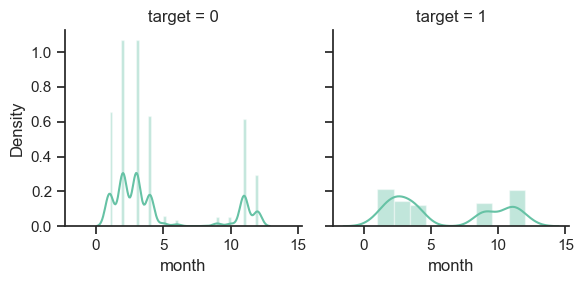

In [32]:
#рисуем график
graph = sns.FacetGrid(train_df, col="target")
graph.map(sns.distplot, "month")

Данные графики имеют схожести, но в принципе различия заметны. Поэтому добавим месяц в факторы анализа.

Видим, что в 5, 6, 7, 8 месяц наш таргет (Алиса) не посещает сайты. Запоминаем эту информацию.

In [42]:
# Добавляем месяц в факторы анализа

test_df["month"] = test_df["time1"].dt.month

Делаем датасеты со временем для проверки: подходит ли нам фактор времени

In [37]:
# Функция для расчета времени в сессии (в секундах)

def get_total_time(row): 
    time_length = row.shape[0] - 1 
    i = time_length 
    while pd.isnull( row [ i ]): 
        i -= 1 
    return (row[i] - row[0]) / np.timedelta64(1,'s')

In [38]:
# Создаем датасеты со временем

train_time = train_df[times] 
test_time = test_df[times]

In [39]:
# Рассчитываем общее время каждой сессии

total_time_train = []
for row in train_time.values:
    total_time_train.append(get_total_time(row))
total_time_train = np.array(total_time_train).reshape(-1,1).astype(int)

total_time_test = []
for row in test_time.values:
    total_time_test.append(get_total_time(row))
total_time_test = np.array(total_time_test).reshape(-1,1).astype(int)

In [40]:
# Прикрепляем общее время сессии к датасетам

train_df['total time train'] = total_time_train
test_df['total time test'] = total_time_test

c:\Users\m2108448\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
c:\Users\m2108448\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

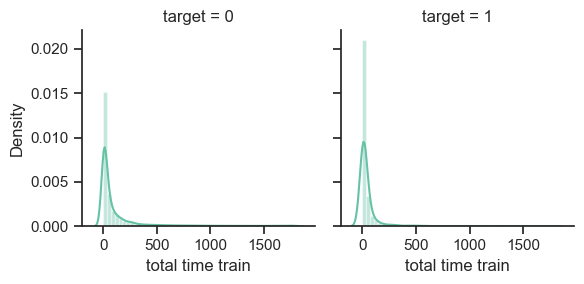

In [41]:
# Рисуем график
graph = sns.FacetGrid(train_df, col="target")
graph.map(sns.distplot, "total time train")

Не будем включать время в факторы анализа, так как графики схожи. 

Проверим, подходит ли нам в факторы день недели.

In [43]:
train_df["day"]=train_df["time1"].dt.dayofweek
train_df.groupby(['target',"day"]).count()

site1  time1  site2  time2  site3  time3  site4  time4  site5  \
target day                                                                  
0      0    39637  39637  39637  39099  39637  38608  39637  38191  39637   
       1    48151  48151  48151  47458  48151  46882  48151  46373  48151   
       2    55933  55933  55933  55309  55933  54705  55933  54219  55933   
       3    43660  43660  43660  42997  43660  42346  43660  41814  43660   
       4    40794  40794  40794  40217  40794  39724  40794  39314  40794   
       5    15758  15758  15758  15569  15758  15360  15758  15226  15758   
       6     7331   7331   7331   7155   7331   7007   7331   6898   7331   
1      0      876    876    876    876    876    873    876    873    876   
       1      508    508    508    508    508    506    508    506    508   
       2       38     38     38     38     38     38     38     37     38   
       3      487    487    487    485    487    484    487    484    487   
       4      346    346    346    346    346    345    346    345    346   
       5       41     41     41     41     41     41     41     41     41   
       6        1      1      1      0      1      0      1      0      1   

            time5  ...  site7  time7  site8  time8  site9  time9  site10  \
target day         ...                                                     
0      0    37781  ...  39637  37035  39637  36690  39637  36304   39637   
       1    45906  ...  48151  45072  48151  44646  48151  44198   48151   
       2    53791  ...  55933  52875  55933  52489  55933  52085   55933   
       3    41325  ...  43660  40495  43660  40122  43660  39715   43660   
       4    38909  ...  40794  38198  40794  37891  40794  37589   40794   
       5    15060  ...  15758  14773  15758  14635  15758  14522   15758   
       6     6777  ...   7331   6580   7331   6488   7331   6409    7331   
1      0      870  ...    876    869    876    868    876    867     876   
       1      503  ...    508    498    508    496    508    496     508   
       2       37  ...     38     37     38     36     38     36      38   
       3      484  ...    487    481    487    481    487    481     487   
       4      345  ...    346    344    346    342    346    342     346   
       5       41  ...     41     40     41     40     41     40      41   
       6        0  ...      1      0      1      0      1      0       1   

            time10  month  total time train  
target day                                   
0      0     35952  39637             39637  
       1     43828  48151             48151  
       2     51671  55933             55933  
       3     39346  43660             43660  
       4     37271  40794             40794  
       5     14406  15758             15758  
       6      6320   7331              7331  
1      0       866    876               876  
       1       493    508               508  
       2        36     38                38  
       3       481    487               487  
       4       342    346               346  
       5        40     41                41  
       6         0      1                 1  

[14 rows x 22 columns]

c:\Users\m2108448\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
c:\Users\m2108448\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

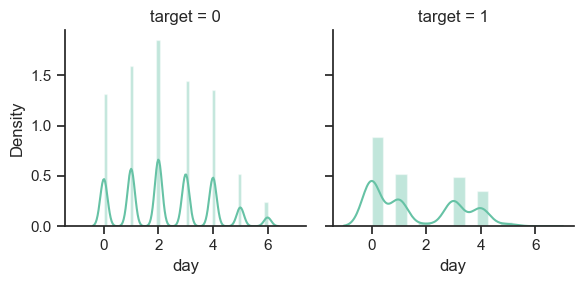

In [44]:
graph = sns.FacetGrid(train_df, col="target")
graph.map(sns.distplot, 'day')

Хороший фактор. Очень разные графики.

Видим, что во 2, 5 и 6 дни недели таргет посещает сайты заметно реже, но возьмем только 6 день для точности

In [48]:
# Добавляем день недели в факторы анализа

test_df["day"] = test_df["time1"].dt.dayofweek

Проверяем день месяца.

In [45]:
train_df["date"] = train_df["time1"].dt.day
train_df.groupby(['target',"date"]).count()

site1  time1  site2  time2  site3  time3  site4  time4  site5  \
target date                                                                  
0      1         2      2      2      1      2      0      2      0      2   
       2      4860   4860   4860   4787   4860   4733   4860   4684   4860   
       3      4458   4458   4458   4366   4458   4270   4458   4209   4458   
       4     20164  20164  20164  20005  20164  19866  20164  19737  20164   
       5        87     87     87     66     87     56     87     53     87   
       12    28920  28920  28920  28560  28920  28229  28920  27900  28920   
       13     8282   8282   8282   8186   8282   8090   8282   7995   8282   
       14     7701   7701   7701   7555   7701   7417   7701   7310   7701   
       15     5860   5860   5860   5751   5860   5656   5860   5592   5860   
       16     6278   6278   6278   6141   6278   6008   6278   5906   6278   
       17    13699  13699  13699  13484  13699  13300  13699  13167  13699   
       18    11921  11921  11921  11686  11921  11483  11921  11336  11921   
       19    19079  19079  19079  18891  19079  18692  19079  18532  19079   
       20    13444  13444  13444  13255  13444  13079  13444  12935  13444   
       21    11506  11506  11506  11386  11506  11269  11506  11162  11506   
       22    10213  10213  10213  10010  10213   9858  10213   9747  10213   
       23     2651   2651   2651   2531   2651   2424   2651   2359   2651   
       24    10985  10985  10985  10837  10985  10710  10985  10589  10985   
       25    15171  15171  15171  14971  15171  14799  15171  14670  15171   
       26    16786  16786  16786  16621  16786  16447  16786  16301  16786   
       27    13539  13539  13539  13406  13539  13254  13539  13131  13539   
       28     8335   8335   8335   8204   8335   8085   8335   7985   8335   
       29     7322   7322   7322   7223   7322   7138   7322   7064   7322   
       30     2520   2520   2520   2466   2520   2426   2520   2399   2520   
       31     7481   7481   7481   7415   7481   7343   7481   7272   7481   
1      2        39     39     39     38     39     38     39     37     39   
       4        41     41     41     41     41     41     41     41     41   
       12      476    476    476    476    476    474    476    474    476   
       13       79     79     79     79     79     79     79     79     79   
       14      179    179    179    179    179    179    179    179    179   
       15      159    159    159    159    159    159    159    159    159   
       16      112    112    112    111    112    111    112    111    112   
       17      152    152    152    152    152    152    152    152    152   
       18       56     56     56     56     56     55     56     55     56   
       19      101    101    101    101    101    101    101    101    101   
       20       58     58     58     58     58     58     58     58     58   
       22      100    100    100    100    100    100    100    100    100   
       24      364    364    364    364    364    362    364    362    364   
       25      176    176    176    176    176    176    176    176    176   
       27       20     20     20     19     20     19     20     19     20   
       28       20     20     20     20     20     19     20     19     20   
       29      143    143    143    143    143    143    143    143    143   
       31       22     22     22     22     22     21     22     21     22   

             time5  ...  time7  site8  time8  site9  time9  site10  time10  \
target date         ...                                                      
0      1         0  ...      0      2      0      2      0       2       0   
       2      4640  ...   4546   4860   4511   4860   4473    4860    4432   
       3      4144  ...   4032   4458   3982   4458   3922    4458    3878   
       4     19596  ...  19341  20164  19217  20164  19104   20164   18999   
       5        50  ...     50    

c:\Users\m2108448\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
c:\Users\m2108448\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

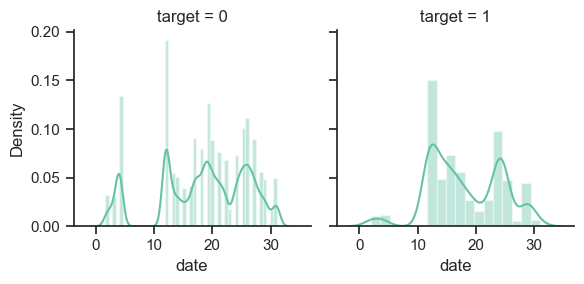

In [46]:
graph = sns.FacetGrid(train_df, col="target")
graph.map(sns.distplot, "date")

Разные графики, поэтому фактор одобряем

In [47]:
# Добавляем день месяца в факторы анализа

test_df["date"] = test_df["time1"].dt.day

Проверяем час суток как фактор анализа.

In [49]:
train_df["hour"] = train_df["time1"].dt.hour
train_df.groupby(['target',"hour"]).count()

site1  time1  site2  time2  site3  time3  site4  time4  site5  \
target hour                                                                  
0      7       341    341    341    333    341    323    341    315    341   
       8     25369  25369  25369  25070  25369  24836  25369  24657  25369   
       9     31703  31703  31703  31358  31703  30979  31703  30661  31703   
       10    33676  33676  33676  33355  33676  33102  33676  32877  33676   
       11    30795  30795  30795  30447  30795  30153  30795  29860  30795   
       12    17080  17080  17080  16849  17080  16629  17080  16454  17080   
       13    22356  22356  22356  21985  22356  21663  22356  21427  22356   
       14    27302  27302  27302  27001  27302  26723  27302  26499  27302   
       15    21600  21600  21600  21223  21600  20886  21600  20606  21600   
       16    17860  17860  17860  17598  17860  17364  17860  17161  17860   
       17    12212  12212  12212  11982  12212  11763  12212  11577  12212   
       18     3719   3719   3719   3628   3719   3532   3719   3453   3719   
       19     1540   1540   1540   1481   1540   1418   1540   1379   1540   
       20     1200   1200   1200   1149   1200   1086   1200   1054   1200   
       21     1705   1705   1705   1664   1705   1606   1705   1562   1705   
       22     1467   1467   1467   1399   1467   1348   1467   1312   1467   
       23     1339   1339   1339   1282   1339   1221   1339   1181   1339   
1      9        38     38     38     38     38     37     38     37     38   
       11        3      3      3      2      3      2      3      2      3   
       12      340    340    340    340    340    340    340    340    340   
       13      196    196    196    195    196    194    196    194    196   
       14        4      4      4      4      4      3      4      3      4   
       15       40     40     40     39     40     39     40     39     40   
       16      879    879    879    879    879    878    879    878    879   
       17      618    618    618    618    618    618    618    618    618   
       18      179    179    179    179    179    176    179    175    179   

             time5  ...  site8  time8  site9  time9  site10  time10  month  \
target hour         ...                                                      
0      7       309  ...    341    286    341    279     341     272    341   
       8     24446  ...  25369  23889  25369  23693   25369   23525  25369   
       9     30373  ...  31703  29675  31703  29388   31703   29165  31703   
       10    32651  ...  33676  32059  33676  31840   33676   31656  33676   
       11    29621  ...  30795  28886  30795  28678   30795   28439  30795   
       12    16308  ...  17080  15897  17080  15792   17080   15682  17080   
       13    21190  ...  22356  20566  22356  20368   22356   20158  22356   
       14    26262  ...  27302  25631  27302  25441   27302   25251  27302   
       15    20338  ...  21600  19607  21600  19352   21600   19140  21600   
       16    16974  ...  17860  16486  17860  16320   17860   16150  17860   
       17    11413  ...  12212  10972  12212  10840   12212   10698  12212   
       18     3382  ...   3719   3210   3719   3148    3719    3099   3719   
       19     1324  ...   1540   1237   1540   1211    1540    1183   1540   
       20     1017  ...   1200    923   1200    902    1200     877   1200   
       21     1525  ...   1705   1420   1705   1394    1705    1364   1705   
       22     1278  ...   1467   1175   1467   1155    1467    1135   1467   
       23     1138  ...   1339   1042   1339   1021    1339    1000   1339   
1      9        37  ...     38     37     38     37      38      37     38   
       11        2  ...      3      2      3      2       3       2      3   
       12      339  ...    340    339    340    339     340     339    340   
       13      194  ...    196    189    196    189     196     188    196   
       14        3  ...      4    

c:\Users\m2108448\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
c:\Users\m2108448\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

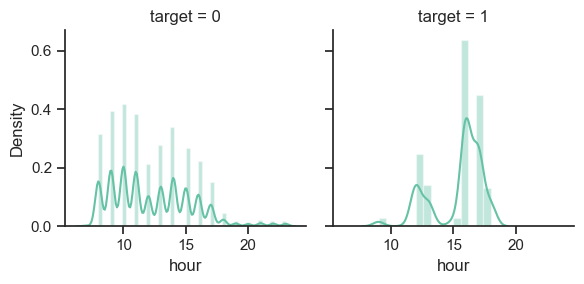

In [50]:
graph = sns.FacetGrid(train_df, col="target")
graph.map(sns.distplot, 'hour')

Графики кардинально отличаются, добавляем в факторы анализа

In [51]:
# Добавляем час суток как фактор

test_df["hour"] = test_df["time1"].dt.hour

Добавим факторы, которые мы заметили по графикам: например, когда Алиса совсем не помещает сайты по статистике обучающих данных

In [52]:
# Добавляем дополнительные факторы времени, дней, месяца

train_df['target_hour'] = np.where((train_df['hour']>=19) | (train_df['hour']<=8) | (train_df['hour']==10), 1, 0)
test_df['target_hour'] = np.where((test_df['hour']>=19) | (test_df['hour']<=8) | (test_df['hour']==10), 1, 0)

train_df['target_day'] = np.where((train_df['day']==2) | (train_df['day']==6), 1, 0)
test_df['target_day'] = np.where((test_df['day']==2) | (test_df['day']==6), 1, 0)

train_df['target_date'] = np.where((train_df['date']==1) | (train_df['date']==3) | (train_df['date']==5) | (train_df['date']==21) | (train_df['date']==23) | (train_df['date']==26), 1, 0)
test_df['target_date'] = np.where((test_df['date']==1) | (test_df['date']==3) | (test_df['date']==5) | (test_df['date']==21) | (test_df['date']==23) | (test_df['date']==26), 1, 0)

train_df['target_month'] = np.where((train_df['month']==10) | ((train_df['month']>=5)&(train_df['month']<=10)), 1, 0)
test_df['target_month'] = np.where((test_df['month']==10) | ((test_df['month']>=5)&(test_df['month']<=10)), 1, 0)

In [53]:
# Создаем векторы параметров по которым мы будем определять таргет и обучать модель

time_factors_train = train_df[['target_hour','target_day','target_date','target_month','total time train']]
time_factors_test = test_df[['target_hour','target_day','target_date','target_month','total time test']]

Создадим два файла для тестовых и тренировочных данных с айдишиками сайтов по сессиям 

In [54]:
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites].fillna(0).to_csv('train_sessions_text.txt', sep=' ', index=None, header=None)
test_df[sites].fillna(0).to_csv('test_sessions_text.txt', sep=' ', index=None, header=None)

In [55]:
# Создаем матрицы с факторами и id сайтов, на которых будем обучать и тестировать модели

from sklearn.feature_extraction.text import TfidfVectorizer


tfidf = TfidfVectorizer(ngram_range=(1, 3), max_features=50000)
with open('train_sessions_text.txt') as inp_train_file:
    x_train = tfidf.fit_transform(inp_train_file)
with open('test_sessions_text.txt') as inp_test_file:
    x_test = tfidf.transform(inp_test_file)
	

In [56]:
# Прикрепряем заданные параметры разделения (с помощью горизонтального объединения)

from scipy.sparse import hstack

x_train = hstack([x_train,time_factors_train])
x_test = hstack([x_test,time_factors_test])
# формируется массив y_train для обучения моделей 
y_train = train_df['target'].values

In [57]:
# Создаем вектор гиперпараметров

C = np.linspace(1, 10, 10)
hyperparameters = dict(C = C)

после выполнения этого кода у нас будет словарь hyperparameters с ключом "C", содержащим вектор значений [1.0, 2.0, 3.0, ..., 10.0], который может быть использован для выбора оптимального значения гиперпараметра C при обучении логистической регрессии.

In [59]:
# Задаем логистическую регрессию и делим выборку на 3 части для кросс-валидации
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit

log = LogisticRegression(max_iter = 5000)
time_split = TimeSeriesSplit(n_splits=3)

In [60]:
# Выбираем оптимальный гиперпараметр 

from sklearn.model_selection import GridSearchCV
# метод перекрестной проверки

log_model = GridSearchCV(log, hyperparameters,
scoring='roc_auc', n_jobs=1, cv=time_split, verbose=1)

после выполнения этого кода у нас будет объект log_model, который является моделью перекрестной проверки с перебором гиперпараметров логистической регрессии. При обучении log_model будут перебираться различные значения гиперпараметра C, и для каждого значения будет выполнена кросс-валидация для оценки качества модели на временных данных. В результате log_model будет содержать оптимальное значение гиперпараметра C и соответствующую модель логистической регрессии с лучшими параметрами.

In [61]:
# Считаем модели и выбираем оптимальную по лучшим roc и auc

best_local_model = log_model.fit(x_train,y_train)
 
print('Best C:', best_local_model.best_estimator_.get_params()['C'])
print('Best Roc Auc:', best_local_model.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best C: 8.0
Best Roc Auc: 0.9746570919087062


В данном коде выполняется обучение модели с перекрестной проверкой (Cross-Validation) для выбора оптимального значения гиперпараметра C для логистической регрессии. Затем выводятся значения лучшего значения C и соответствующего ROC AUC (значение метрики качества).

0.97 - очень хороший результат

In [68]:
# Прогноз по логистической регрессии

y_pred = log_model.predict(x_test)
y_pred[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [67]:
# Предсказанные вероятности классов для тестовых данных
y_test = log_model.predict_proba(x_test)
y_test[:10]


array([[9.83625009e-01, 1.63749908e-02],
       [9.99999013e-01, 9.86637098e-07],
       [9.99999816e-01, 1.83766764e-07],
       [9.99999973e-01, 2.72066422e-08],
       [9.98344712e-01, 1.65528816e-03],
       [9.99997689e-01, 2.31090021e-06],
       [9.99998972e-01, 1.02823375e-06],
       [9.99851920e-01, 1.48080201e-04],
       [9.99999988e-01, 1.19719387e-08],
       [8.05396682e-01, 1.94603318e-01]])